In [1]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

%matplotlib inline
import seaborn as sns

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split

from tensorflow.keras.callbacks import EarlyStopping

from utilize.data import *
from utilize.transform import *
from utilize.plot import *
from utilize.test import *

Found 60 users data.


# Load Dataset

In [2]:
# Load all the data from Extrasenory dataset
X, y, M, user_index, feature_names, label_names = load_all_data(['1155FF54-63D3-4AB2-9863-8385D0BD0A13'])

In [3]:
time_domain_keywords = ['mean', 'std', 'moment', 'percentile', 'entropy', 'magnitude_stats', '3d']
frequency_domain_keywords = ['spectrum', 'log_energy_band', 'spectral_entropy', 'magnitude_spectrum']

time_domain_columns = [col for col in feature_names if any(keyword in col for keyword in time_domain_keywords)]
frequency_domain_columns = [col for col in feature_names if any(keyword in col for keyword in frequency_domain_keywords)]

# Display the identified columns
print("Time-Domain Columns:")
for col in time_domain_columns:
    print(col)

print("\nFrequency-Domain Columns:")
for col in frequency_domain_columns:
    print(col)

Time-Domain Columns:
raw_acc:magnitude_stats:mean
raw_acc:magnitude_stats:std
raw_acc:magnitude_stats:moment3
raw_acc:magnitude_stats:moment4
raw_acc:magnitude_stats:percentile25
raw_acc:magnitude_stats:percentile50
raw_acc:magnitude_stats:percentile75
raw_acc:magnitude_stats:value_entropy
raw_acc:magnitude_stats:time_entropy
raw_acc:magnitude_spectrum:spectral_entropy
raw_acc:3d:mean_x
raw_acc:3d:mean_y
raw_acc:3d:mean_z
raw_acc:3d:std_x
raw_acc:3d:std_y
raw_acc:3d:std_z
raw_acc:3d:ro_xy
raw_acc:3d:ro_xz
raw_acc:3d:ro_yz
proc_gyro:magnitude_stats:mean
proc_gyro:magnitude_stats:std
proc_gyro:magnitude_stats:moment3
proc_gyro:magnitude_stats:moment4
proc_gyro:magnitude_stats:percentile25
proc_gyro:magnitude_stats:percentile50
proc_gyro:magnitude_stats:percentile75
proc_gyro:magnitude_stats:value_entropy
proc_gyro:magnitude_stats:time_entropy
proc_gyro:magnitude_spectrum:spectral_entropy
proc_gyro:3d:mean_x
proc_gyro:3d:mean_y
proc_gyro:3d:mean_z
proc_gyro:3d:std_x
proc_gyro:3d:std_y
pro

# Feature Engineering

In [4]:
corr_matrix = np.corrcoef(X, rowvar=False)
threshold = 0.95
columns_to_remove = np.where(np.abs(corr_matrix) > threshold)
columns_to_remove = [(i, j) for i, j in zip(columns_to_remove[0], columns_to_remove[1]) if i != j]
dedup_columns = list(set([col[0] for col in columns_to_remove]))
X = np.delete(X, dedup_columns, axis=1)
# X = X[:,dedup_columns]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


# Data Preprocessing

In [5]:
# Only select body state label
# target_label = ['LYING_DOWN', 'SITTING', 'FIX_walking', 'FIX_running', 'BICYCLING', 'OR_standing']
target_labels = ['LYING_DOWN', 'SITTING', 'FIX_walking']
# Fill the Nan with mean value and normalize all the data 
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('std_scaler', StandardScaler())
])

In [6]:
import warnings
warnings.simplefilter("ignore")

In [7]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM

# RNN Model

In [8]:
def run_rnn_model(X_train, X_test, y_train, y_test, M_train, M_test, y_train_sw1D):
    model = Sequential()
    model.add(Dense(1, input_shape=(X_train.shape[1],), activation="relu"))
    model.add(Dropout(0.2))
    model.compile(loss="binary_crossentropy",
                  optimizer='sgd',
                  metrics=['accuracy'])
    callback = EarlyStopping(monitor='loss',
                                patience=3)
    model.fit(X_train, y_train,
                        epochs = 20, 
                        batch_size = 5,
                        validation_data = (X_test, y_test),
                        callbacks=[callback],
                        verbose=0,
                        sample_weight = y_train_sw1D)
    # y_pred = model.predict(X_test)
    # print(classification_report(y_test, (y_pred > 0.5).astype(int)))
    accuracy, precision, recall, f1 = evaluate_model(model, X_test, y_test)
    return accuracy, precision, recall, f1

# LSTM Model

In [9]:
def run_lstm_model(X_train, X_test, y_train, y_test, M_train, M_test, y_train_sw1D):
    X_train_1 = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test_1 = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    
    model = Sequential()
    model.add(LSTM(1, input_shape=(1, X_train_1.shape[2]), activation="sigmoid"))
    model.add(Dropout(0.2))
    model.compile(loss = "binary_crossentropy",
                optimizer = 'sgd',
                metrics = ['accuracy'])
    callback = EarlyStopping(monitor='loss',
                                patience=3)
    history = model.fit(X_train_1, y_train,
                    epochs = 20, 
                    batch_size = 5,
                    validation_data = (X_test_1, y_test), 
                    callbacks=[callback],
                    verbose=0,
                    sample_weight = y_train_sw1D)
    # Store the performance metric for this split
    accuracy, precision, recall, f1 = evaluate_model(model, X_test_1, y_test)
    return accuracy, precision, recall, f1

# Random Forest Model

In [10]:
def run_random_forest_model(X_train, X_test, y_train, y_test, M_train, M_test, y_train_sw1D):
    rf = RandomForestClassifier(class_weight = 'balanced', n_estimators = 10, min_samples_split = 10)
    rf.fit(X_train, y_train, sample_weight = y_train_sw1D)
    accuracy, precision, recall, f1 = evaluate_model(rf, X_test, y_test)
    return accuracy, precision, recall, f1

# SVM Model

In [11]:
def run_svm_model(X_train, X_test, y_train, y_test, M_train, M_test, y_train_sw1D):
    svm = SVC(kernel='linear', random_state=42)
    history = svm.fit(X_train, y_train, sample_weight = y_train_sw1D)
    # y_pred = svm.predict(X_test)
    accuracy, precision, recall, f1 = evaluate_model(svm, X_test, y_test)
    return accuracy, precision, recall, f1

In [12]:

run_model = {
    'rnn': run_rnn_model,
    'lstm': run_lstm_model,
    'random_forest': run_random_forest_model,
    'svm': run_svm_model
}
models = ['rnn', 'lstm', 'random_forest', 'svm']



# Cross Validation for Time Series Data

In [13]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


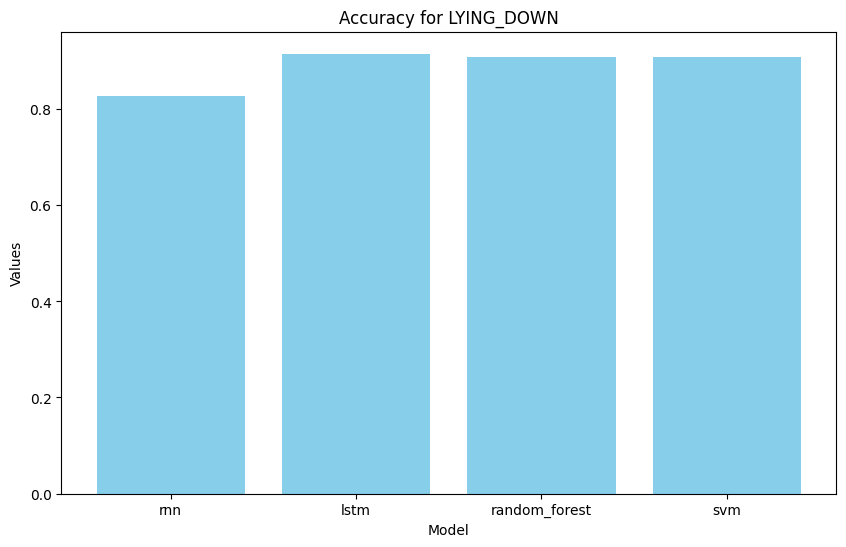

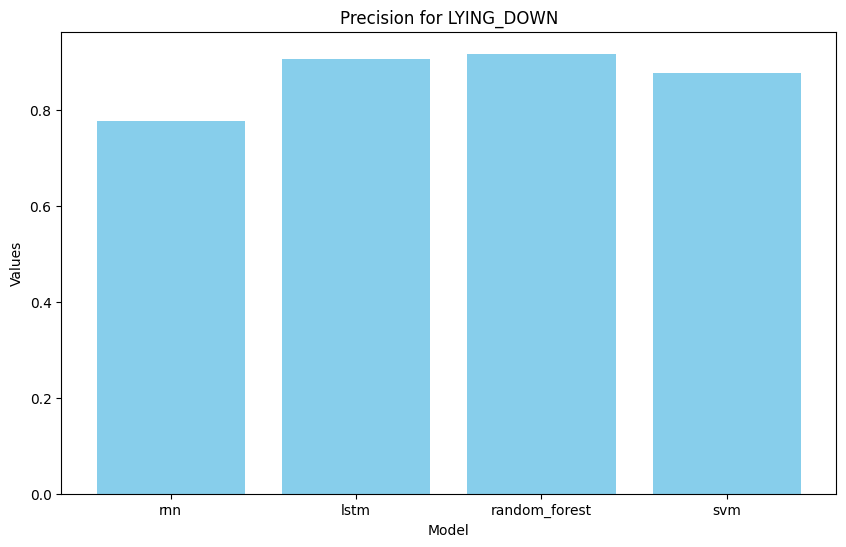

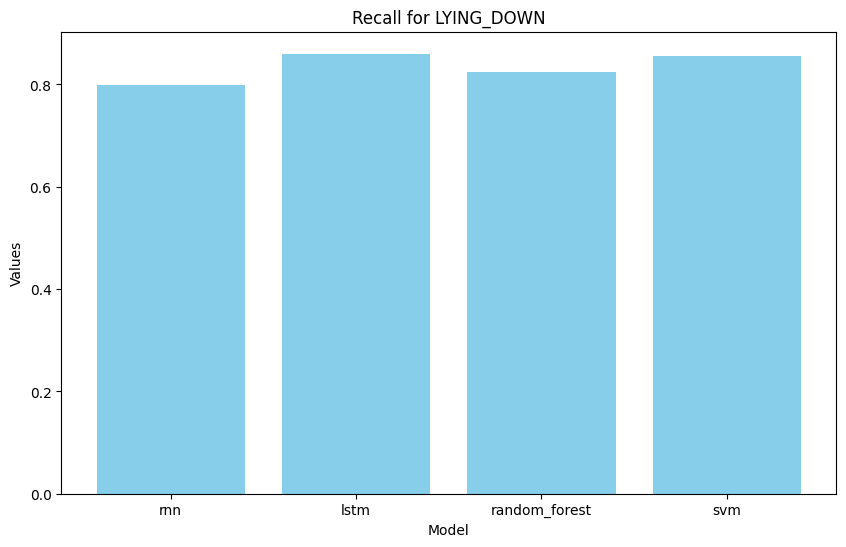

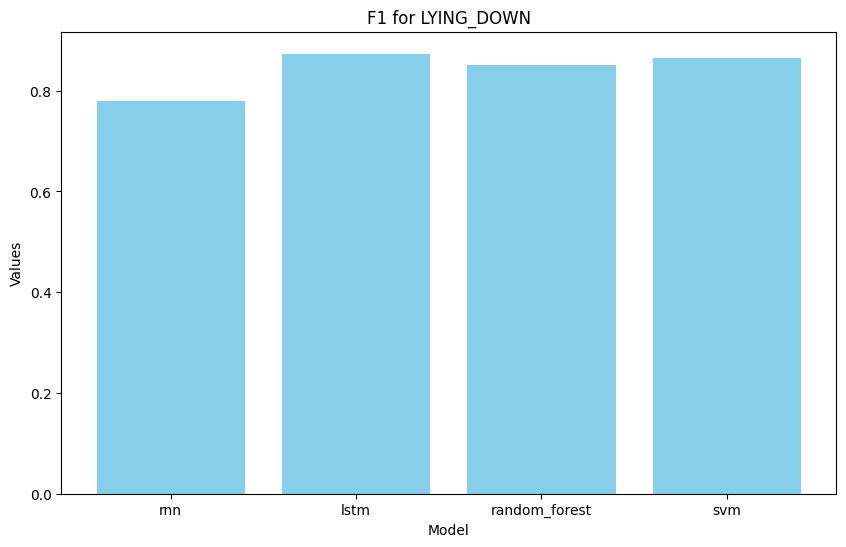

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


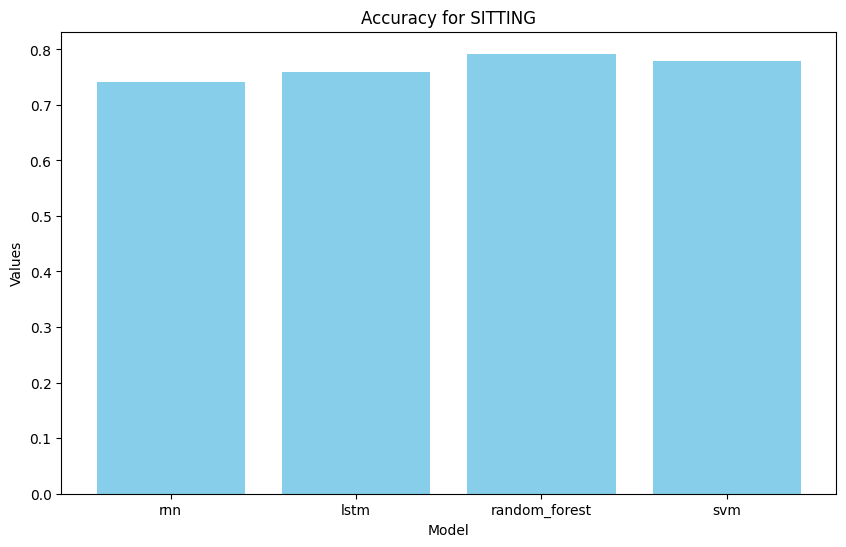

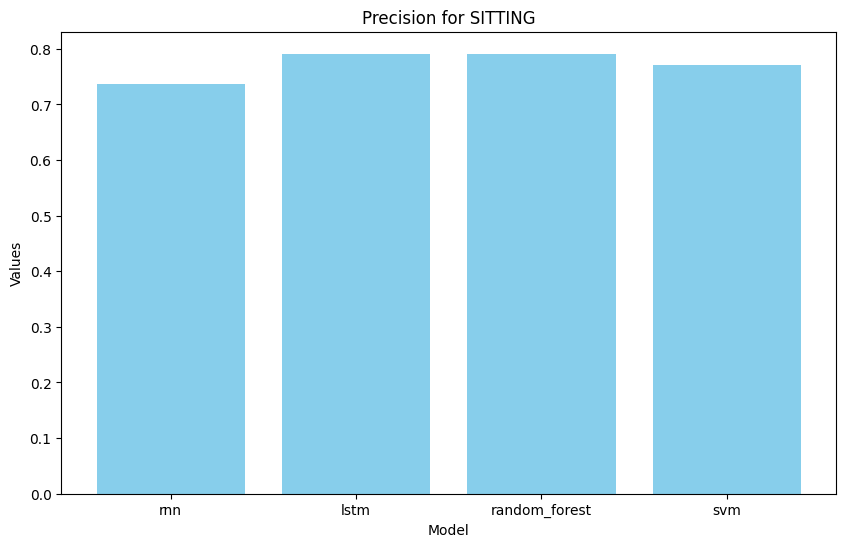

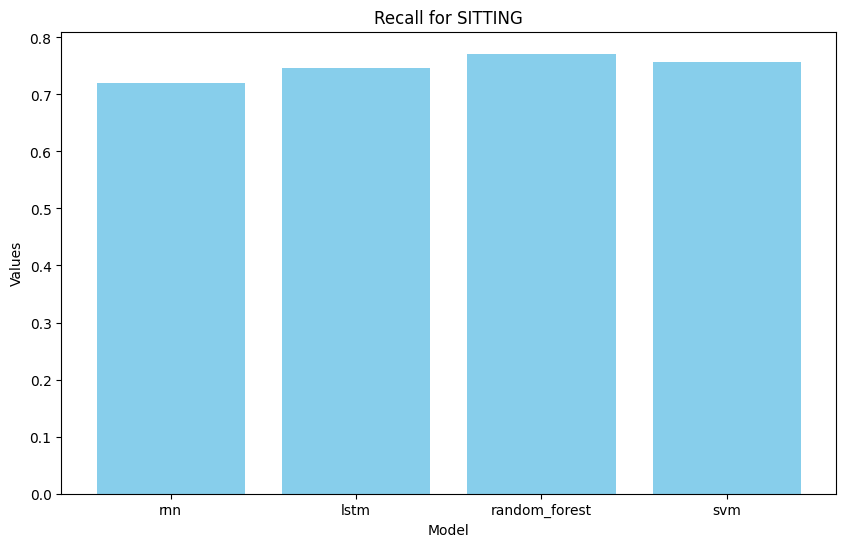

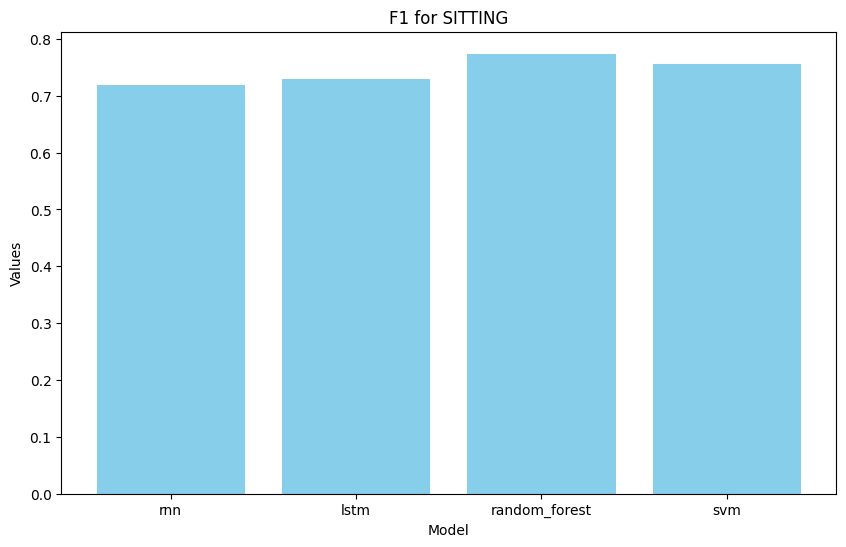

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


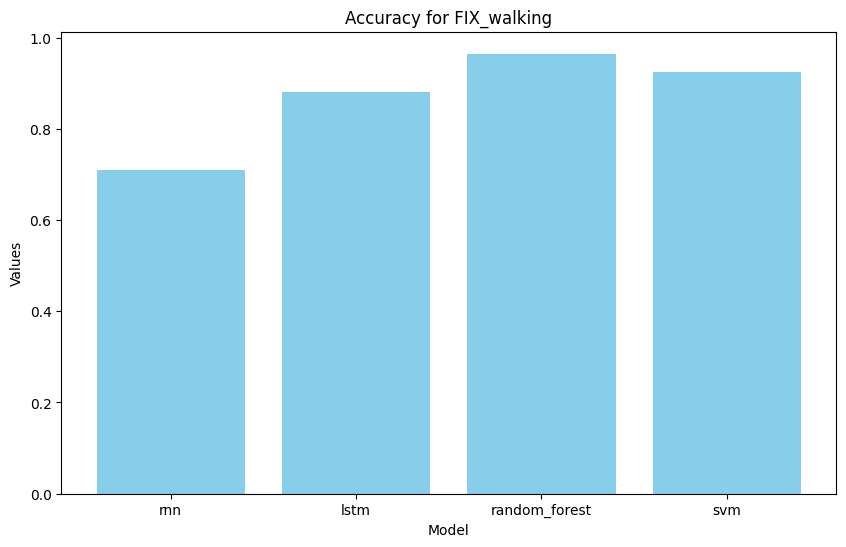

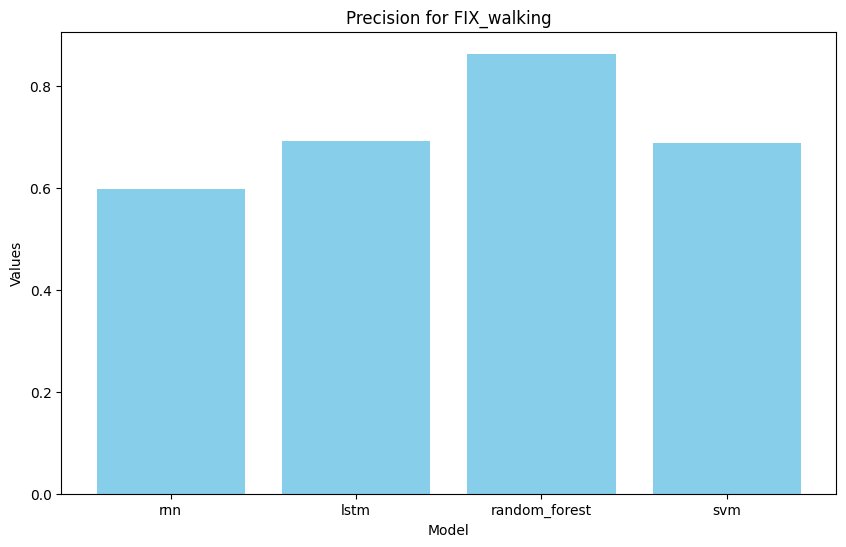

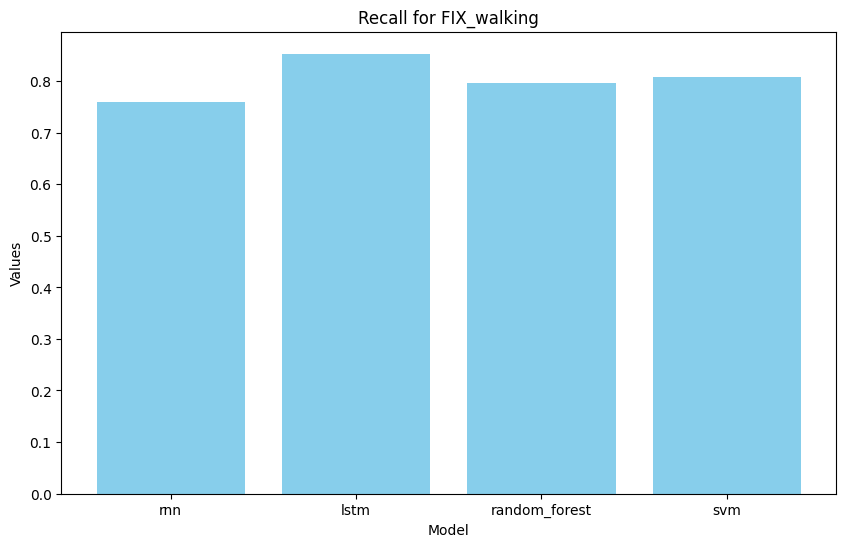

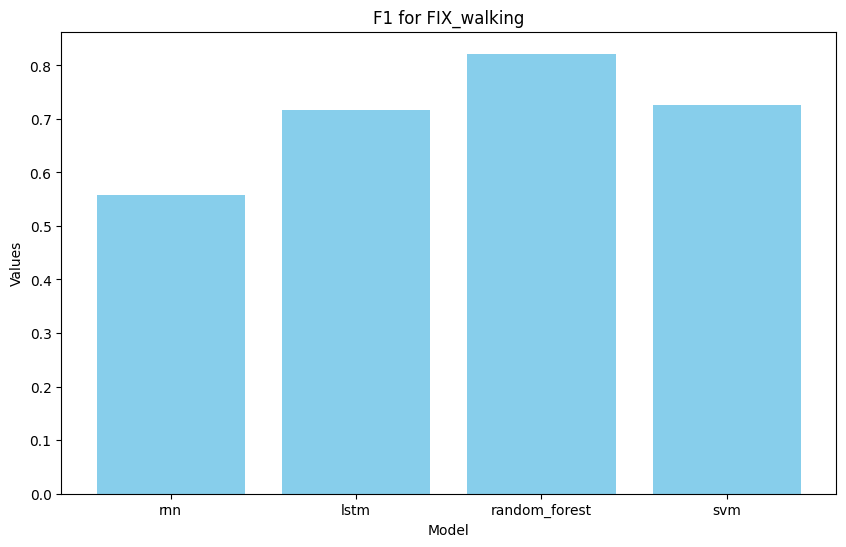

In [14]:

for target_label in target_labels:
    accuracy_scores = {}
    precision_scores = {}
    recall_scores = {}
    f1_scores = {}
    X_new, y_new, M_new = select_target_labels(X, y, M, target_label, label_names, drop_all_zero = False)
    X_new = pipeline.fit_transform(X_new, y_new)
    for train_index, test_index in tscv.split(X_new, y_new):
        # Split the data into training and test sets based on the current split indices
        X_train, X_test = X_new[train_index], X_new[test_index]
        y_train, y_test = y_new[train_index], y_new[test_index]
        M_train, M_test = M_new[train_index], M_new[test_index]
        # To swap 0 and 1, simply do 
        y_train_sampleweight = np.abs(1-M_train)
        y_train_sw1D = np.zeros(y_train_sampleweight.shape[0])
        for i in range(len(y_train_sw1D)):
            y_train_sw1D[i] = np.sum(y_train_sampleweight[i])/M_train.shape[1]
        
        for model in models:
            accuracy, precision, recall, f1 = run_model[model](X_train,X_test,y_train,y_test,M_train,M_test,y_train_sw1D)
            accuracy_scores[model] = accuracy_scores[model]+[accuracy] if accuracy_scores.get(model) else [accuracy]
            precision_scores[model] = precision_scores[model]+[precision] if precision_scores.get(model) else [precision]
            recall_scores[model] = recall_scores[model]+[recall] if recall_scores.get(model) else [recall]
            f1_scores[model] = f1_scores[model]+[f1] if f1_scores.get(model) else [f1]
    
    plot_metric(models, [np.mean(val) for val in accuracy_scores.values()], f'Accuracy for {target_label}')
    plot_metric(models, [np.mean(val) for val in precision_scores.values()], f'Precision for {target_label}')
    plot_metric(models, [np.mean(val) for val in recall_scores.values()], f'Recall for {target_label}')
    plot_metric(models, [np.mean(val) for val in f1_scores.values()], f'F1 for {target_label}')

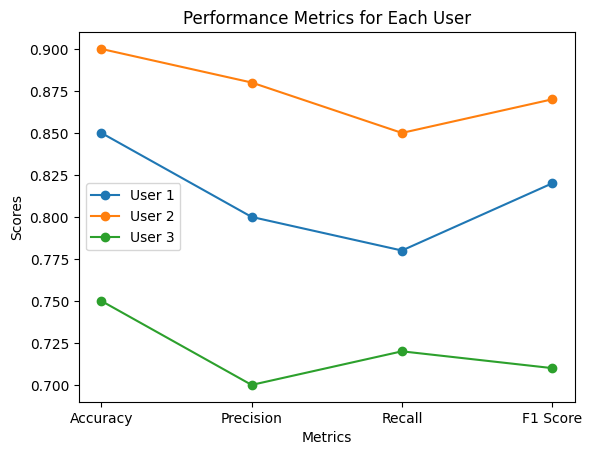

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
users = ['User 1', 'User 2', 'User 3']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
data = {
    'User 1': [0.85, 0.80, 0.78, 0.82],
    'User 2': [0.90, 0.88, 0.85, 0.87],
    'User 3': [0.75, 0.70, 0.72, 0.71]
}

# Preparing data for plotting
num_metrics = len(metrics)
index = np.arange(num_metrics)

# Plotting the data
fig, ax = plt.subplots()

for user in users:
    scores = data[user]
    ax.plot(index, scores, marker='o', label=user)

# Adding titles and labels
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics for Each User')
ax.set_xticks(index)
ax.set_xticklabels(metrics)
ax.legend()

# Display the graph
plt.show()